# Mouse bulk RNA analysis
1. Create cleaned up sample sheet 
2. Data QC
3. PCA Plots
4. DE tests done in `14b_mouse_bulk_analysis_R.ipynb` 
5. DE gene lists and GO terms:
    - Take lists from 4., calculate GO terms, plot expression heatmaps

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = "/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/raw_data/230210_rnaseq_mouse/"
RESULTS_DIR = "/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/230210_rnaseq_mouse/"

region_to_color = {
    "Calvaria"  : "#e377c2",
    "Brain"     : "#1f77b4",
    "Femur"     : "#ff7f0e",
    "Humerus"   : "#279e68",
    "Meninges"  : "#d62728",
    "Pelvis"    : "#aa40fc",
    "Scapula"   : "#8c564b",
    "Vertebra"  : "#b5bd61",
}

condition_to_color = {
    'MCAo'      : "#1f77b4",
    'Naive'     : "#ff7f0e",
    'Sham'      : "#279e68",
}

bones = ["Calvaria", "Vertebra", "Scapula", "Femur", "Humerus", "Pelvis"]

# Create sample sheet with all necessary info

In [3]:
df = pd.read_csv(Path(DATA_DIR, "fastqs", "Project_588_lims.csv"), index_col=0)
df

Sample_Name Sample_NameLIMS FID_comment Sample_Project  \
Sample_ID                                                                 
Sample_23L000374   23L000374       Calvari1N          A1    Project_588   
Sample_23L000375   23L000375       Calvari2N          B1    Project_588   
Sample_23L000376   23L000376     Calvaria3_N          C1    Project_588   
Sample_23L000377   23L000377      Calvaria4n          D1    Project_588   
Sample_23L000378   23L000378      Calvaria5n          E1    Project_588   
...                      ...             ...         ...            ...   
Sample_23L000465   23L000465     Femur2_mcao         D12    Project_588   
Sample_23L000466   23L000466     Femur3_mcao         E12    Project_588   
Sample_23L000467   23L000467         femur4m         F12    Project_588   
Sample_23L000468   23L000468         femur5m         G12    Project_588   
Sample_23L000469   23L000469         femur6m         H12    Project_588   

                 Library Protocol  Mergefastq    Read length Organism  
Sample_ID                                                              
Sample_23L000374    mRNA Ligation        True  100-10-10-100    mouse  
Sample_23L000375    mRNA Ligation        True  100-10-10-100    mouse  
Sample_23L000376    mRNA Ligation        True  100-10-10-100    mouse  
Sample_23L000377    mRNA Ligation        True  100-10-10-100    mouse  
Sample_23L000378    mRNA Ligation        True  100-10-10-100    mouse  
...                           ...         ...            ...      ...  
Sample_23L000465    mRNA Ligation        True  100-10-10-100    mouse  
Sample_23L000466    mRNA Ligation        True  100-10-10-100    mouse  
Sample_23L000467    mRNA Ligation        True  100-10-10-100    mouse  
Sample_23L000468    mRNA Ligation        True  100-10-10-100    mouse  
Sample_23L000469    mRNA Ligation        True  100-10-10-100    mouse  

[95 rows x 8 columns]

In [4]:
def get_region(sample):
    if "alvari" in sample:
        return "Calvaria"
    if ("capul" in sample) or ("kapul" in sample):
        return "Scapula"
    if "umeru" in sample:
        return "Humerus"
    if "ertebr" in sample:
        return "Vertebra"
    if "elvis" in sample:
        return "Pelvis"
    if "emur" in sample:
        return "Femur"
    else:
        raise ValueError(f"... sample = {sample}")
        
def get_condition(sample):
    if sample.endswith("sham"):
        return "Sham"
    if sample.endswith("mcao") or sample.endswith("m"):
        return "MCAo"
    if sample.endswith("N") or sample.endswith("n") or (sample[-2] == "N"):
        return "Naive"
    else:
        raise ValueError(f"... sample = {sample}")    
        
def get_sample_nr(sample):
    return "".join([c for c in sample if c.isdigit()])

In [5]:
df["region"] = df["Sample_NameLIMS"].apply(lambda s: get_region(s))
df["condition"] = df["Sample_NameLIMS"].apply(lambda s: get_condition(s))
df["animal"] = df["Sample_NameLIMS"].apply(lambda s: get_condition(s) + "_" + get_sample_nr(s))

for r in ["Calvaria","Vertebra","Scapula","Femur","Humerus","Pelvis"]:
    df[r] = "other"
    df.loc[df["region"] == r,r] = r
    
for c in ["Naive","Sham","MCAo"]:
    df[c] = "other"
    df.loc[df["condition"] == c,c] = c

In [6]:
df

Sample_Name Sample_NameLIMS FID_comment Sample_Project  \
Sample_ID                                                                 
Sample_23L000374   23L000374       Calvari1N          A1    Project_588   
Sample_23L000375   23L000375       Calvari2N          B1    Project_588   
Sample_23L000376   23L000376     Calvaria3_N          C1    Project_588   
Sample_23L000377   23L000377      Calvaria4n          D1    Project_588   
Sample_23L000378   23L000378      Calvaria5n          E1    Project_588   
...                      ...             ...         ...            ...   
Sample_23L000465   23L000465     Femur2_mcao         D12    Project_588   
Sample_23L000466   23L000466     Femur3_mcao         E12    Project_588   
Sample_23L000467   23L000467         femur4m         F12    Project_588   
Sample_23L000468   23L000468         femur5m         G12    Project_588   
Sample_23L000469   23L000469         femur6m         H12    Project_588   

                 Library Protocol  Mergefastq    Read length Organism  \
Sample_ID                                                               
Sample_23L000374    mRNA Ligation        True  100-10-10-100    mouse   
Sample_23L000375    mRNA Ligation        True  100-10-10-100    mouse   
Sample_23L000376    mRNA Ligation        True  100-10-10-100    mouse   
Sample_23L000377    mRNA Ligation        True  100-10-10-100    mouse   
Sample_23L000378    mRNA Ligation        True  100-10-10-100    mouse   
...                           ...         ...            ...      ...   
Sample_23L000465    mRNA Ligation        True  100-10-10-100    mouse   
Sample_23L000466    mRNA Ligation        True  100-10-10-100    mouse   
Sample_23L000467    mRNA Ligation        True  100-10-10-100    mouse   
Sample_23L000468    mRNA Ligation        True  100-10-10-100    mouse   
Sample_23L000469    mRNA Ligation        True  100-10-10-100    mouse   

                    region condition   animal  Calvaria Vertebra Scapula  \
Sample_ID                                                                  
Sample_23L000374  Calvaria     Naive  Naive_1  Calvaria    other   other   
Sample_23L000375  Calvaria     Naive  Naive_2  Calvaria    other   other   
Sample_23L000376  Calvaria     Naive  Naive_3  Calvaria    other   other   
Sample_23L000377  Calvaria     Naive  Naive_4  Calvaria    other   other   
Sample_23L000378  Calvaria     Naive  Naive_5  Calvaria    other   other   
...                    ...       ...      ...       ...      ...     ...   
Sample_23L000465     Femur      MCAo   MCAo_2     other    other   other   
Sample_23L000466     Femur      MCAo   MCAo_3     other    other   other   
Sample_23L000467     Femur      MCAo   MCAo_4     other    other   other   
Sample_23L000468     Femur      MCAo   MCAo_5     other    other   other   
Sample_23L000469     Femur      MCAo   MCAo_6     other    other   other   

                  Femur Humerus Pelvis  Naive   Sham   MCAo  
Sample_ID                                                    
Sample_23L000374  other   other  other  Naive  other  other  
Sample_23L000375  other   other  other  Naive  other  other  
Sample_23L000376  other   other  other  Naive  other  other  
Sample_23L000377  other   other  other  Naive  other  other  
Sample_23L000378  other   other  other  Naive  other  other  
...                 ...     ...    ...    ...    ...    ...  
Sample_23L000465  Femur   other  other  other  other   MCAo  
Sample_23L000466  Femur   other  other  other  other   MCAo  
Sample_23L000467  Femur   other  other  other  other   MCAo  
Sample_23L000468  Femur   other  other  other  other   MCAo  
Sample_23L000469  Femur   other  other  other  other   MCAo  

[95 rows x 20 columns]

In [7]:
df.to_csv(Path(DATA_DIR, "Project_588_lims_clean.csv"))

# QC checks

In [8]:
df = pd.read_csv(Path(DATA_DIR, "counts", "nfc-rnaseq-3.9", "report1090", "output", "results", "star_salmon", "salmon.merged.gene_counts.tsv"), sep = "\t", index_col=0)
df_meta = pd.read_csv(Path(DATA_DIR, "Project_588_lims_clean.csv"),index_col=0)


In [9]:
adata = ad.AnnData(
    X = df.iloc[:,1:].T.values,
    var = df.iloc[:,:1],
    obs = df_meta
)

In [10]:
sc.pp.filter_genes(adata, min_counts=1)

In [11]:
adata

AnnData object with n_obs × n_vars = 95 × 39908
    obs: 'Sample_Name', 'Sample_NameLIMS', 'FID_comment', 'Sample_Project', 'Library Protocol', 'Mergefastq', 'Read length', 'Organism', 'region', 'condition', 'animal', 'Calvaria', 'Vertebra', 'Scapula', 'Femur', 'Humerus', 'Pelvis', 'Naive', 'Sham', 'MCAo'
    var: 'gene_name', 'n_counts'

In [12]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
mt_gene_mask = [gene.startswith('mt-') for gene in adata.var["gene_name"]]
mt_gene_index = np.where(mt_gene_mask)[0]
adata.obs['mt_fraction'] = adata.X[:,mt_gene_index].sum(1) / adata.X.sum(1)

... storing 'Sample_Project' as categorical
... storing 'Library Protocol' as categorical
... storing 'Read length' as categorical
... storing 'Organism' as categorical
... storing 'region' as categorical
... storing 'condition' as categorical
... storing 'animal' as categorical
... storing 'Calvaria' as categorical
... storing 'Vertebra' as categorical
... storing 'Scapula' as categorical
... storing 'Femur' as categorical
... storing 'Humerus' as categorical
... storing 'Pelvis' as categorical
... storing 'Naive' as categorical
... storing 'Sham' as categorical
... storing 'MCAo' as categorical
... storing 'gene_name' as categorical
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packag

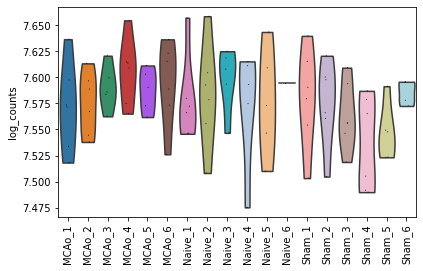

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


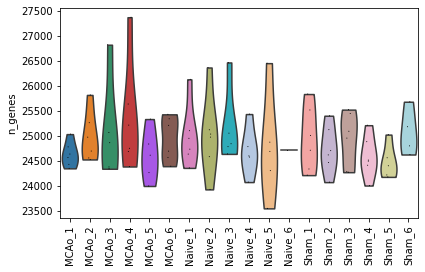

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


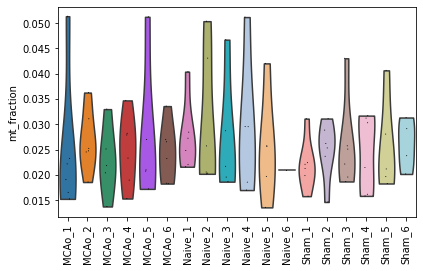

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


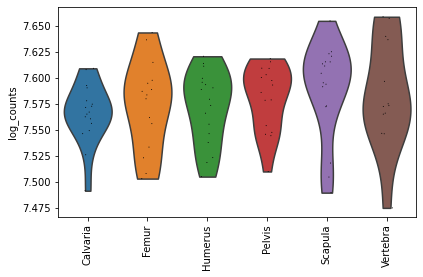

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


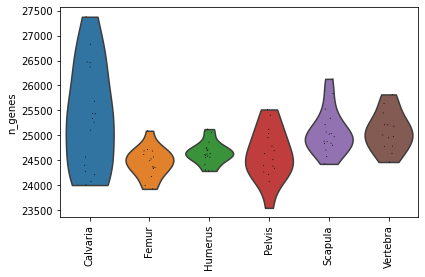

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


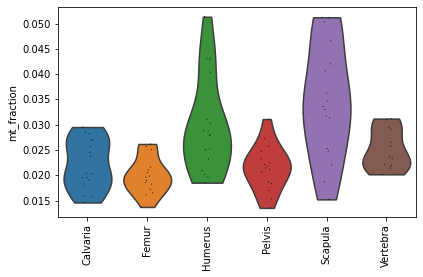

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


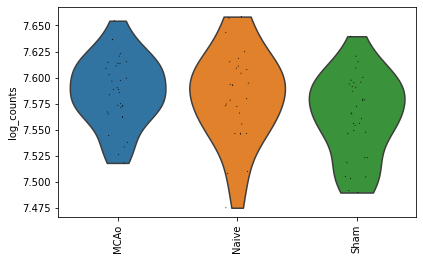

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


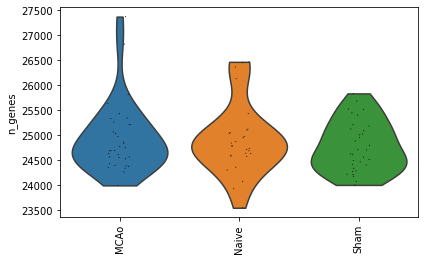

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


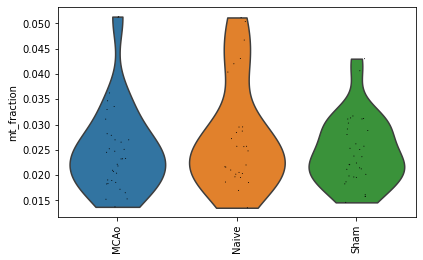

In [13]:
for key in ['animal', 'region', 'condition']:
    sc.pl.violin(adata, ['log_counts'], groupby=key, size=1, log=False,rotation=90)
    sc.pl.violin(adata, ['n_genes'], groupby=key, size=1, log=False,rotation=90)
    sc.pl.violin(adata, ['mt_fraction'], groupby=key, size=1, log=False,rotation=90)

# PCA

In [3]:
df = pd.read_csv(Path(DATA_DIR, "counts", "nfc-rnaseq-3.9", "report1090", "output", "results", "star_salmon", "salmon.merged.gene_counts.tsv"), sep = "\t", index_col=0)
df_meta = pd.read_csv(Path(DATA_DIR, "Project_588_lims_clean.csv"),index_col=0)

adata = ad.AnnData(
    X = df.iloc[:,1:].T.values,
    var = df.iloc[:,:1],
    obs = df_meta
)

sc.pp.filter_genes(adata, min_counts=1)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.filter_genes(adata,min_counts=10)

adata.var = adata.var.reset_index().set_index("gene_name")
adata.var_names = adata.var_names.astype(str)
adata.var_names_make_unique()

adata.obs["region"] = adata.obs["region"].astype("category")
adata.obs["condition"] = adata.obs["condition"].astype("category")
adata.uns["region_colors"] = [region_to_color[r] for r in adata.obs["region"].cat.categories]
adata.uns["condition_colors"] = [condition_to_color[c] for c in adata.obs["condition"].cat.categories]



In [5]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='cell_ranger')

In [11]:
sc.tl.pca(adata, n_comps=50)

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


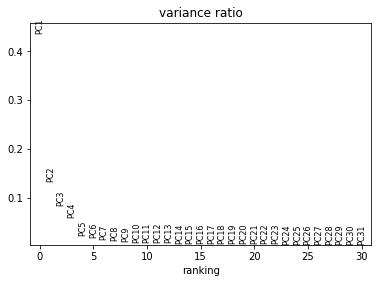

In [12]:
sc.pl.pca_variance_ratio(adata)

In [6]:
sc.tl.pca(adata, n_comps=9)

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


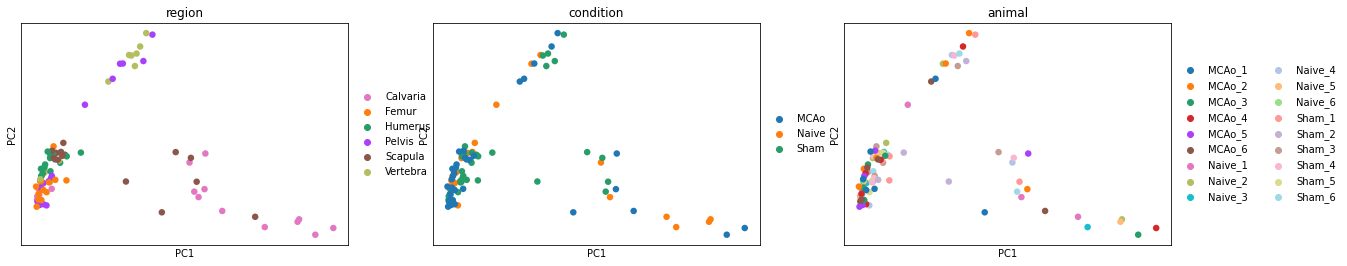

In [14]:
sc.pl.pca(adata, color=["region", "condition", "animal"], s=170)

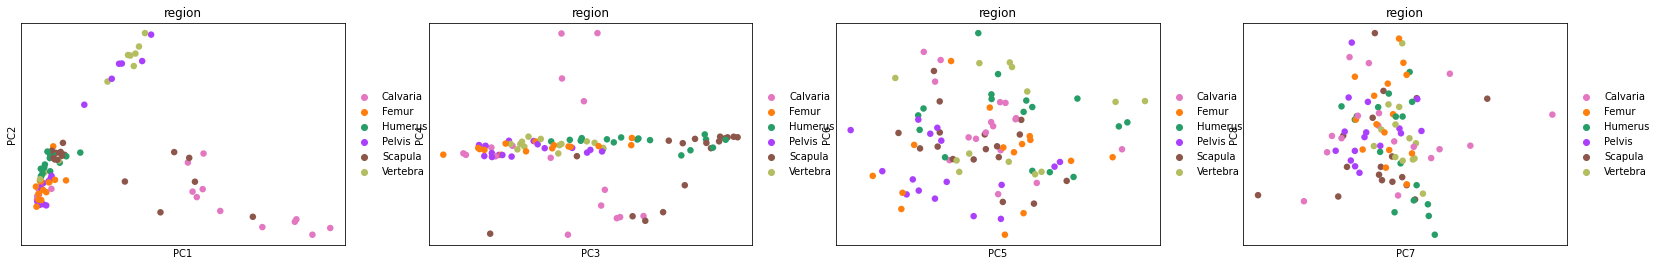

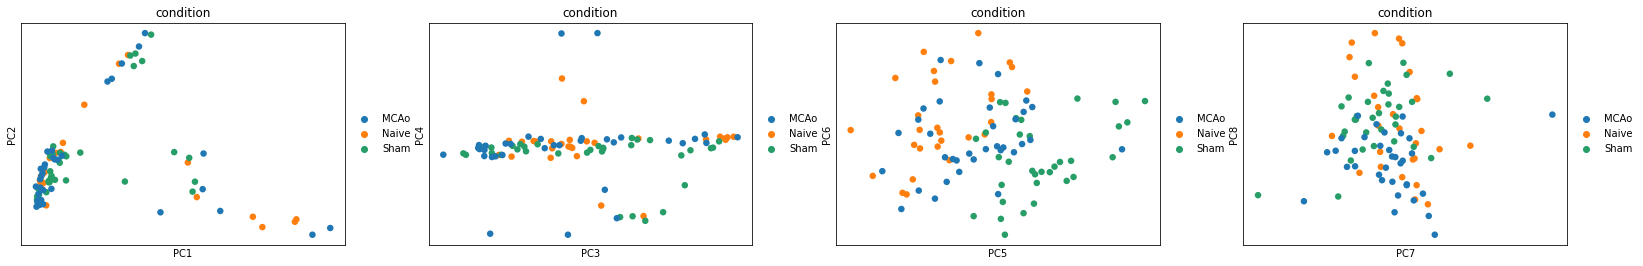

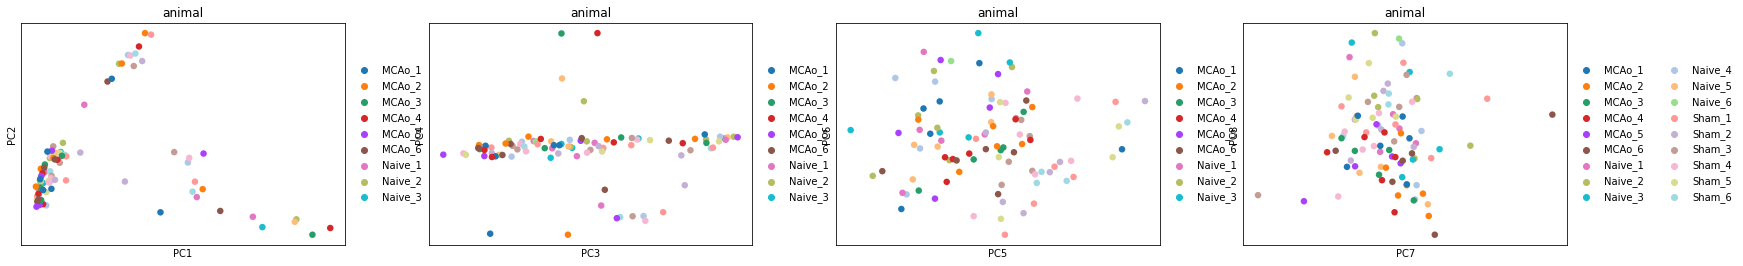

In [24]:
sc.pl.pca(adata, color="region", s=170, components=["1,2","3,4","5,6","7,8"])
sc.pl.pca(adata, color="condition", s=170, components=["1,2","3,4","5,6","7,8"])
sc.pl.pca(adata, color="animal", s=170, components=["1,2","3,4","5,6","7,8"])

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 110
plt.rcParams['savefig.dpi'] = 150
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


[]

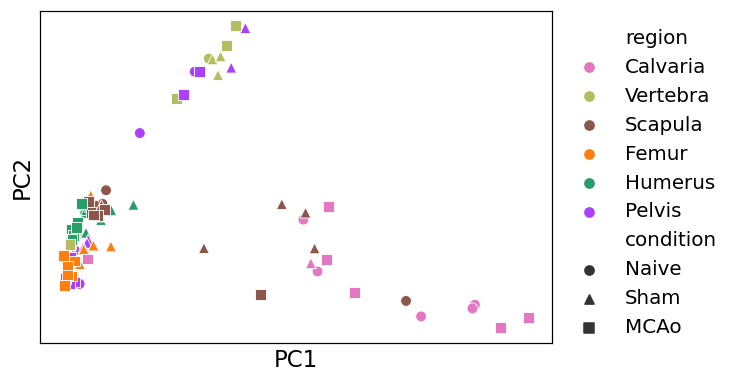

In [12]:
df = pd.DataFrame(
    data = {
        "PC1":adata.obsm["X_pca"][:,0], 
        "PC2":adata.obsm["X_pca"][:,1],
        "region":adata.obs["region"].tolist(),
        "condition":adata.obs["condition"].tolist(),
    }
)

sns.scatterplot(
    data=df, x="PC1", y="PC2", hue="region", hue_order=bones, s=50,
    palette=region_to_color, style="condition", markers={"Naive":"o", "Sham":"^", "MCAo":"s"}
)
ax = plt.gca()
ax.legend(frameon=False,bbox_to_anchor=(1,1))#, loc="lower right")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.gcf().savefig("./figures/bulk_RNA_pca.png", bbox_inches = "tight", transparent=True)

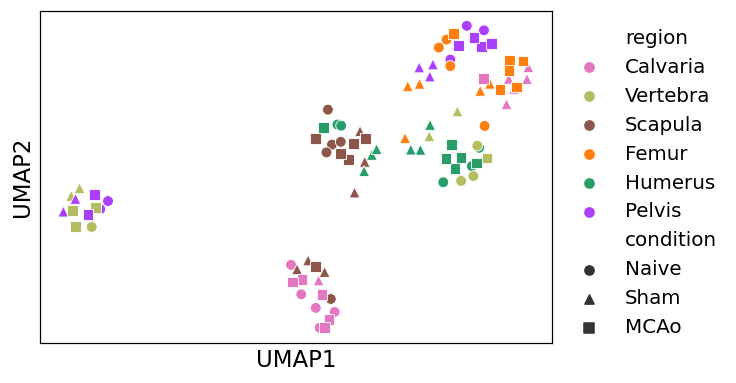

In [11]:
# Note: this umap is on the pca with n_comps=9

df = pd.DataFrame(
    data = {
        "UMAP1":adata.obsm["X_umap"][:,0], 
        "UMAP2":adata.obsm["X_umap"][:,1],
        "region":adata.obs["region"].tolist(),
        "condition":adata.obs["condition"].tolist(),
    }
)

sns.scatterplot(
    data=df, x="UMAP1", y="UMAP2", hue="region", hue_order=bones, s=50,
    palette=region_to_color, style="condition", markers={"Naive":"o", "Sham":"^", "MCAo":"s"}
)
ax = plt.gca()
ax.legend(frameon=False,bbox_to_anchor=(1,1))#, loc="lower right")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.gcf().savefig("./figures/bulk_RNA_umap.png", bbox_inches = "tight", transparent=True)
plt.show()

# DE gene lists and GO terms

In [3]:
df = pd.read_csv(Path(DATA_DIR, "counts", "nfc-rnaseq-3.9", "report1090", "output", "results", "star_salmon", "salmon.merged.gene_counts.tsv"), sep = "\t", index_col=0)
df_meta = pd.read_csv(Path(DATA_DIR, "Project_588_lims_clean.csv"),index_col=0)

adata = ad.AnnData(
    X = df.iloc[:,1:].T.values,
    var = df.iloc[:,:1],
    obs = df_meta
)

sc.pp.filter_genes(adata, min_counts=1)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.filter_genes(adata,min_counts=10)

adata.var = adata.var.reset_index().set_index("gene_name")
adata.var_names = adata.var_names.astype(str)
adata.var_names_make_unique()


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 70
plt.rcParams['savefig.dpi'] = 150
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [101]:
from gprofiler_plotting import gprofiler_enrich
import scipy.cluster.hierarchy as sch
from matplotlib import colors

def GO_plot(genes,plot_heatmap=True,save_en=False,save_hm=False,show_plots=False,return_dfs=False,max_n_genes=150):
    """
    """
    rcParams['figure.figsize']= (4.8,4.8)
    enrich_df = gprofiler_enrich(genes,
                                 save=save_en,
                                 plot=show_plots)
    
    rcParams['figure.figsize']= (4.5+min(max_n_genes,len(genes)),6.5)
    if plot_heatmap:
        enrich_df = enrich_df.sort_values('p_value')[:20]
        hm_df = plot_GO_heatmap(genes,enrich_df,show=show_plots,save=save_hm,max_n_genes=max_n_genes)
    
        if return_dfs:
            return enrich_df, hm_df
    if return_dfs:
        return enrich_df 
    
def plot_GO_heatmap(genes,df,show=False,save=False,reorder_heatmap=True,max_n_genes=150):
    """
    max_n_genes: only show the top max_n_genes sorted based on number of GO terms
    """
    df_tmp = pd.DataFrame(index=df["name"],
                 columns=genes,
                 data={g:df["intersections"].apply(lambda gs: g in gs).astype(int).tolist() for g in genes}
                )
    if (len(df_tmp.columns) > 1) and max_n_genes:
        cols = df_tmp.sum().sort_values(ascending=False)[:min(len(df_tmp.columns),max_n_genes)].index.tolist()
        df_tmp = df_tmp[cols]
    
    if reorder_heatmap and (len(df_tmp.columns) > 1):
        # Reorder by linkage clustering
        pairwise_distances = sch.distance.pdist(df_tmp.values.T)
        linkage = sch.linkage(pairwise_distances, method="complete")
        cluster_distance_threshold = pairwise_distances.max() / 2
        idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, criterion="distance")
        idx = np.argsort(idx_to_cluster_array)
        df_tmp = df_tmp[df_tmp.columns[idx]]
        # Invert gene order if genes with fewer terms are on the left side of the heatmap
        mean_1st_half = df_tmp[df_tmp.columns[:len(df_tmp.columns)//2]].values.mean()
        mean_2nd_half = df_tmp[df_tmp.columns[len(df_tmp.columns)//2:]].values.mean()
        if mean_1st_half < mean_2nd_half:
            df_tmp = df_tmp[df_tmp.columns[::-1]]
    cmap = plt.get_cmap('Greens')
    new_cmap = truncate_colormap(cmap, 0.15, 0.8)
    hm = sns.heatmap(df_tmp,cmap=new_cmap, square=True, linewidths=.1, xticklabels=1, yticklabels=1, cbar=False)
    if save:
        fig = hm.get_figure()
        fig.savefig(save,bbox_inches = "tight")
    if show:
        plt.show()
    else:
        plt.close()
    return df_tmp 

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


import scipy.cluster.hierarchy as sch
import scipy


def plot_expr_heatmap(adata, genes, groupby="region",show=True,save=False):
    """
    """
    #genes = df_hm.columns.tolist()
    X = adata[:,genes].X
    
    # compute correlation matrix
    if scipy.sparse.issparse(X):
        cor_mat = np.corrcoef(X.toarray(), rowvar=False)
    else:
        cor_mat = np.corrcoef(X, rowvar=False)
    
    # ordering
    pairwise_distances = sch.distance.pdist(cor_mat)
    linkage = sch.linkage(pairwise_distances, method="complete")
    cluster_distance_threshold = pairwise_distances.max() / 2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, criterion="distance")
    idx = np.argsort(idx_to_cluster_array)
    
    genes_ordered = np.array(genes)[idx].tolist()
    
    hm = sc.pl.heatmap(adata, genes_ordered, groupby=groupby, show_gene_labels=True, dendrogram=True, show=False)
    if save:
        plt.gcf().savefig(save, bbox_inches = "tight", transparent=True)
    if show:
        plt.show()
    else:
        plt.close()
    
    hm = sc.pl.heatmap(adata, genes_ordered, groupby=groupby, show_gene_labels=True, standard_scale="var",dendrogram=True, show=False)
    if save:
        plt.gcf().savefig("_scaled.".join(str(save).rsplit(".",1)), bbox_inches = "tight", transparent=True)
    if show:
        plt.show()
    else:
        plt.close()


In [92]:
def convert_ids_to_symbols(ids):
    """
    """
    var_tmp = adata.var.reset_index().set_index("gene_id")
    
    valid_ids_idxs = [idx for idx,i in enumerate(ids) if i in var_tmp.index]
    valid_ids = [i for i in ids if i in var_tmp.index]
    symbols = var_tmp.loc[valid_ids,"gene_name"].tolist()
    all_symbols = ids.copy()
    for idx, sym in zip(valid_ids_idxs,symbols):
        all_symbols[idx] = sym
    
    return all_symbols
    

def get_DE_lists(df, key1, key2):
    """Get gene list of DE genes, DE genes up regulated, DE genes down regulated, for different threshold settings
    """
    
    pval_th = 0.05
    settings = ["LFc0", "LFc1", "LFc2"]
    DE_genes = {s:{} for s in settings}
    
    for s in settings:
        LFc_th = float(s.split("LFc")[-1])
        DE_genes[s]["all"] = df.loc[(df["padj"] < pval_th) & (df["log2FoldChange"].abs() > LFc_th)].sort_values("stat", ascending=False)
        DE_genes[s][f"up in {key1}"] = df.loc[(df["padj"] < pval_th) & (df["log2FoldChange"] > LFc_th)].sort_values("stat", ascending=False)
        DE_genes[s][f"up in {key2}"] = df.loc[(df["padj"] < pval_th) & (df["log2FoldChange"] < -LFc_th)].sort_values("stat", ascending=True)
        for key in ["all", f"up in {key1}", f"up in {key2}"]:
            #print(DE_genes[s][key].index.tolist())
            #print(convert_ids_to_symbols((["ENSMUSG00000000001.5", "ENSMUSG00000000028.16", "ENSMUSG00000000031.18", "ENSMUSG00000000037.18", "ENSMUSG00000000049.12"])))
            DE_genes[s][key]['genes'] = convert_ids_to_symbols(DE_genes[s][key].index.tolist())
        
    return DE_genes

def priority_of_test(file_name):
    """
    """
    
    if file_name == "region_all_condition_Naive_vs_other":
        return "primary"
    elif file_name == "region_all_condition_Sham_vs_MCAo":
        return "primary"
    elif file_name.startswith("condition") and file_name.endswith("vs_other"):
        return "primary"
    else:
        return "secondary"
    
    
    

In [93]:
columns = ["name","thresholds","condition_test", "region_test", "condition", "region", "group1", "group2", "n_DE", "n_up_in_group1", "n_up_in_group2"]
rows = []
DE_dfs = {}

for file in Path(RESULTS_DIR, "DE_tests").iterdir():
    df = pd.read_csv(file, index_col=0)
    file_name = str(file).split("/")[-1].split(".")[0]
    
    prio = priority_of_test(file_name)
    
    key1 = file_name.split("_")[-3]
    key2 = file_name.split("_")[-1]
    DE_genes = get_DE_lists(df, key1, key2)
    DE_dfs[file_name] = DE_genes
    
    for s in DE_genes:
        const, val, test, group1, _, group2 = file_name.split("_")
        row = [file_name,s,None,None,None,None,group1,group2,len(DE_genes[s]['all']),len(DE_genes[s]['up in '+group1]),len(DE_genes[s]['up in '+group2])]
        row[2] = group1+"_vs_"+group2 if test == "condition" else "None"
        row[3] = group1+"_vs_"+group2 if test == "region" else "None"
        row[4] = "see test" if test == "condition" else val
        row[5] = "see test" if test == "region" else val
        rows.append(row)
    

In [94]:
df = pd.DataFrame(data=rows, columns=columns)
df.to_csv(Path(".","figures","bulk_RNA_DE_GO","N_genes_up_down_regulated.csv"))

In [95]:
adata.obs["region_condition"] = adata.obs["region"].astype(str) + "_" + adata.obs["condition"].astype(str)

In [103]:
import warnings
warnings.filterwarnings("ignore")

In [107]:
MIN_N_GENES = 4

from datetime import datetime
t0 = datetime.now()

# GO terms
for file_name in DE_dfs:
    print(file_name, "   -   ", datetime.now()-t0)
    
    const, val, test, group1, _, group2 = file_name.split("_")
    #name.split("_")
    #print(name)
    
    prio = priority_of_test(file_name)
    
    imp = "important" if prio == "primary" else "other"
    
    for LFc_min in DE_dfs[file_name].keys():
    
        if const == "condition":
            base_dir = Path(".","figures","bulk_RNA_DE_GO",imp,'region_test',val,f"LFc_min{LFc_min}")
            fname_up = f"{group1}_up"
            fname_do = f"{group1}_down"
            #path1 = Path(".","figures","bulk_RNA_DE_GO",imp,'region_test',val,f"LFc_min{LFc_min}",f"{group1}_up")
            #path2 = Path(".","figures","bulk_RNA_DE_GO",imp,'region_test',val,f"LFc_min{LFc_min}",f"{group1}_down")
        elif const == "region":
            base_dir = Path(".","figures","bulk_RNA_DE_GO",imp,'condition_test',val,f"LFc_min{LFc_min}")
            fname_up = f"up_in_{group1}_vs_{group2}"
            fname_do = f"up_in_{group2}_vs_{group1}"
            #path1 = Path(".","figures","bulk_RNA_DE_GO",imp,'condition_test',val,f"LFc_min{LFc_min}",f"up_in_{group1}_vs_{group2}")
            #path2 = Path(".","figures","bulk_RNA_DE_GO",imp,'condition_test',val,f"LFc_min{LFc_min}",f"up_in_{group2}_vs_{group1}")
            
        #print("\t", file_name, "  -  ", str(Path(base_dir,fname_up)))
        if len(DE_dfs[file_name][LFc_min][f'up in {group1}']) >= MIN_N_GENES:
            base_dir.mkdir(parents=True, exist_ok=True)
            _, df_hm = GO_plot(
                DE_dfs[file_name][LFc_min][f'up in {group1}']["genes"].tolist(),
                plot_heatmap=True,
                save_en=Path(base_dir,fname_up+"_enrichment.png"),
                save_hm=Path(base_dir,fname_up+"_GO_per_gene.png"),
                show_plots=False,return_dfs=True,max_n_genes=150
            )
            plot_expr_heatmap(
                adata, df_hm.columns.tolist(), groupby="region_condition",show=False,
                save=Path(base_dir,fname_up+"_expr_heatmap.png")
            )
        if len(DE_dfs[file_name][LFc_min][f'up in {group2}']) >= MIN_N_GENES:
            base_dir.mkdir(parents=True, exist_ok=True)
            _, df_hm = GO_plot(
                DE_dfs[file_name][LFc_min][f'up in {group2}']["genes"].tolist(),
                plot_heatmap=True,
                save_en=Path(base_dir,fname_do+"_enrichment.png"),
                save_hm=Path(base_dir,fname_do+"_GO_per_gene.png"),
                show_plots=False,return_dfs=True,max_n_genes=150
            )
            plot_expr_heatmap(
                adata, df_hm.columns.tolist(), groupby="region_condition",show=False,
                save=Path(base_dir,fname_do+"_expr_heatmap.png"),
            )

condition_Sham_region_Femur_vs_other    -    0:00:00.000274
region_Pelvis_condition_Naive_vs_other    -    0:00:06.357996
condition_MCAo_region_Pelvis_vs_other    -    0:00:06.358193
condition_Sham_region_Calvaria_vs_other    -    0:01:01.368410
region_all_condition_MCAo_vs_other    -    0:03:25.290976
condition_MCAo_region_Vertebra_vs_other    -    0:04:41.619877
region_Pelvis_condition_Naive_vs_MCAo    -    0:04:59.394882
region_Scapula_condition_Naive_vs_Sham    -    0:05:03.377789
condition_Sham_region_Vertebra_vs_other    -    0:06:41.839288
region_all_condition_Sham_vs_other    -    0:06:41.839503
condition_Naive_region_Vertebra_vs_other    -    0:09:23.754034
region_Femur_condition_MCAo_vs_other    -    0:09:33.291552
condition_Sham_region_Scapula_vs_other    -    0:10:39.842578
region_Pelvis_condition_MCAo_vs_other    -    0:12:25.494285
condition_Sham_region_Humerus_vs_other    -    0:12:35.866633
region_all_condition_Sham_vs_MCAo    -    0:13:19.158607
region_Femur_condition_

# Mean expression correlation between sc and bulk

##### Load bulk data

In [13]:
DATA_DIR = "/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/raw_data/230210_rnaseq_mouse/"
RESULTS_DIR = "/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/230210_rnaseq_mouse/"

In [14]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 70
plt.rcParams['savefig.dpi'] = 150
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [15]:
df = pd.read_csv(Path(DATA_DIR, "counts", "nfc-rnaseq-3.9", "report1090", "output", "results", "star_salmon", "salmon.merged.gene_counts.tsv"), sep = "\t", index_col=0)
df_meta = pd.read_csv(Path(DATA_DIR, "Project_588_lims_clean.csv"),index_col=0)

adata = ad.AnnData(
    X = df.iloc[:,1:].T.values,
    var = df.iloc[:,:1],
    obs = df_meta
)
adata.layers["raw"] = adata.X.copy()

sc.pp.filter_genes(adata, min_counts=1)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.filter_genes(adata,min_counts=10)

adata.var = adata.var.reset_index().set_index("gene_name")
adata.var_names = adata.var_names.astype(str)
adata.var_names_make_unique()

adata.obs["region"] = adata.obs["region"].astype("category")
adata.obs["condition"] = adata.obs["condition"].astype("category")
adata.uns["region_colors"] = [region_to_color[r] for r in adata.obs["region"].cat.categories]
adata.uns["condition_colors"] = [condition_to_color[c] for c in adata.obs["condition"].cat.categories]



##### Load sc data

In [16]:
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'oct22'#'april21'
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [17]:
bones = ["Calvaria","Vertebra","Scapula","Femur","Humerus","Pelvis"]

adata_sc = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')

adata_sc.obs["region"] = adata_sc.obs["region"].cat.rename_categories({'Skull': 'Calvaria'})
adata_sc.obs["condition"] = adata_sc.obs["condition"].cat.rename_categories({'MCAO': 'MCAo'})
adata_sc = adata_sc[adata_sc.obs["region"].isin(bones)]

adata_sc_raw = sc.read(DATA_DIR+f'data_merged_april21_wSham.h5ad')
adata_sc.layers["raw"] = adata_sc_raw[adata_sc.obs_names,adata_sc.var_names].X

del adata_sc_raw

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


##### Get data ready for mean calculations

In [18]:
# Add region_condition column
adata.obs["region_condition"] = adata.obs["region"].astype(str) + "_" + adata.obs["condition"].astype(str)
adata_sc.obs["region_condition"] = adata_sc.obs["region"].astype(str) + "_" + adata_sc.obs["condition"].astype(str)

# Reduce to shared genes
shared_vars = list(set(adata.var_names).intersection(set(adata_sc.var_names)))
adata = adata[:,shared_vars]
adata_sc = adata_sc[:,shared_vars]

##### Calculate means on raw data

In [19]:
n_genes = adata.n_vars
data = {"mean_bulk":[],"mean_sc":[],"gene":[],"condition_region":[]}
for rc in adata.obs["region_condition"].unique():
    print(rc)
    a = adata[adata.obs["region_condition"]==rc]
    a_sc = adata_sc[adata_sc.obs["region_condition"]==rc]
    
    mean_bulk = list(np.mean(a.layers["raw"], axis=0))
    mean_sc = list(np.array(a_sc.layers["raw"].mean(axis=0))[0,:])
    #mean_bulk = list(np.sum(a.layers["raw"], axis=0))
    #mean_sc = list(np.array(a_sc.layers["raw"].sum(axis=0))[0,:])
    
    
    data["mean_bulk"] += mean_bulk
    data["mean_sc"] += mean_sc
    data["gene"] += adata.var_names.tolist()
    data["condition_region"] += [rc for _ in range(n_genes)]

Calvaria_Naive
Scapula_Naive
Humerus_Naive
Vertebra_Naive
Pelvis_Naive
Femur_Naive
Calvaria_Sham
Scapula_Sham
Humerus_Sham
Vertebra_Sham
Pelvis_Sham
Femur_Sham
Calvaria_MCAo
Scapula_MCAo
Humerus_MCAo
Vertebra_MCAo
Pelvis_MCAo
Femur_MCAo


In [20]:
df = pd.DataFrame(data)
df["condition"] = df["condition_region"].apply(lambda cr: cr.split("_")[1])
df["region"] = df["condition_region"].apply(lambda cr: cr.split("_")[0])
df["condition_colors"] = df["condition"].apply(lambda c: condition_to_color[c])
df["region_colors"] = df["region"].apply(lambda r: region_to_color[r])

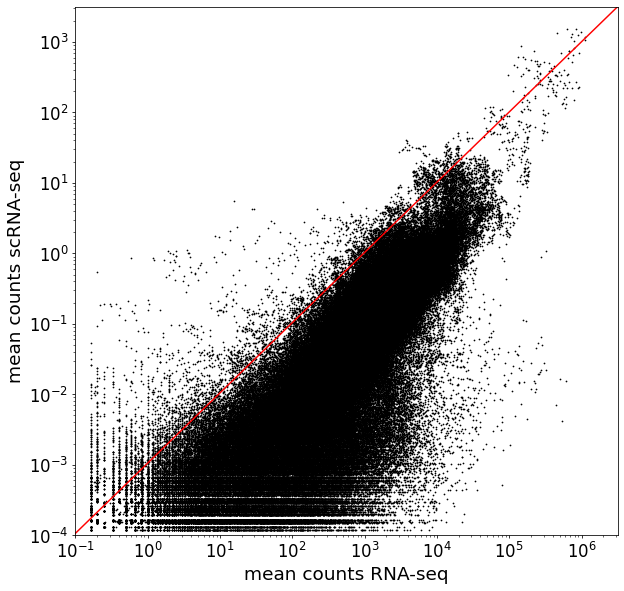

In [118]:
plt.figure(figsize=(10,10))
plt.scatter(df["mean_bulk"].values,df["mean_sc"].values, s=0.6, c="black")
plt.plot([0,10**7],[0,10**7/10**4],c="red")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean counts RNA-seq')
plt.ylabel('mean counts scRNA-seq')
plt.xlim([0.1,10**6.5])
plt.ylim([0.0001,10**3.5])
plt.gcf().savefig("./figures/correlation_sc_vs_bulk.png", bbox_inches = "tight", transparent=True)

##### Check correlations between different cond_region pairs

In [21]:
bones = ['Calvaria', 'Vertebra', 'Scapula', 'Femur', 'Humerus', 'Pelvis']
conditions = ["Naive", "Sham", "MCAo"]

crs = [f"{b}_{c}" for c in conditions for b in bones]

In [22]:
x1 = df["mean_bulk"]
x2 = df["mean_sc"]
filt = (x1.values>0) & (x2.values>0)
x1 = np.log(x1.loc[filt].values)
x2 = np.log(x2.loc[filt].values)
print(np.corrcoef(x1,x2)[0,1])

0.8141510674627607


In [103]:
bones = ['Calvaria', 'Vertebra', 'Scapula', 'Femur', 'Humerus', 'Pelvis']
conditions = ["Naive", "Sham", "MCAo"]

#crs = df["condition_region"].unique()
crs = [f"{b}_{c}" for c in conditions for b in bones]
df_corr_log = pd.DataFrame(index=crs,columns=crs,data=0)
df_corr_lin = pd.DataFrame(index=crs,columns=crs,data=0)
for cr1 in crs:
    for cr2 in crs:
        x1 = df.loc[df["condition_region"]==cr1,"mean_bulk"].values
        x2 = df.loc[df["condition_region"]==cr2,"mean_sc"].values
        df_corr_lin.loc[cr1,cr2] = np.corrcoef(x1,x2)[0,1]
        del x1, x2

        x1 = df.loc[df["condition_region"]==cr1,"mean_bulk"]
        x2 = df.loc[df["condition_region"]==cr2,"mean_sc"]
        filt = (x1.values>0) & (x2.values>0)
        x1 = np.log(x1.loc[filt].values)
        x2 = np.log(x2.loc[filt].values)
        df_corr_log.loc[cr1,cr2] = np.corrcoef(x1,x2)[0,1]

In [110]:
df_corr_log.index.name = "bulk"
df_corr_lin.index.name = "bulk"
df_corr_log.columns.name = "sc"
df_corr_lin.columns.name = "sc"

In [172]:
df_corr_log.iloc[:5,:5]

sc              Calvaria_Naive  Vertebra_Naive  Scapula_Naive  Femur_Naive  \
bulk                                                                         
Calvaria_Naive        0.777047        0.789935       0.807451     0.793661   
Vertebra_Naive        0.813419        0.825488       0.842444     0.831094   
Scapula_Naive         0.778831        0.790326       0.807113     0.796989   
Femur_Naive           0.822959        0.834004       0.852631     0.841415   
Humerus_Naive         0.801751        0.811629       0.830280     0.821368   

sc              Humerus_Naive  
bulk                           
Calvaria_Naive       0.793395  
Vertebra_Naive       0.829943  
Scapula_Naive        0.796769  
Femur_Naive          0.840149  
Humerus_Naive        0.819737

# Test gene lists

Lists:
- DE genes from sc pseudobulk
- inflammatory genes

In [11]:
DATA_DIR = "/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/raw_data/230210_rnaseq_mouse/"
#DATA_DIR = "/Volumes/TOSHIBA_EXT/Promotion/data/A1/raw_data/230210_rnaseq_mouse"
RESULTS_DIR = "/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/230210_rnaseq_mouse/"
#RESULTS_DIR = '/Volumes/TOSHIBA_EXT/Promotion/data/A1/results/230210_rnaseq_mouse/'


# R DE tests
#/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/230210_rnaseq_mouse/DE_tests

In [17]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 70
plt.rcParams['savefig.dpi'] = 300
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [7]:
df = pd.read_csv(Path(DATA_DIR, "counts", "nfc-rnaseq-3.9", "report1090", "output", "results", "star_salmon", "salmon.merged.gene_counts.tsv"), sep = "\t", index_col=0)
df_meta = pd.read_csv(Path(DATA_DIR, "Project_588_lims_clean.csv"),index_col=0)

adata = ad.AnnData(
    X = df.iloc[:,1:].T.values,
    var = df.iloc[:,:1],
    obs = df_meta
)

sc.pp.filter_genes(adata, min_counts=1)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.filter_genes(adata,min_counts=10)

adata.var = adata.var.reset_index().set_index("gene_name")
adata.var_names = adata.var_names.astype(str)
adata.var_names_make_unique()



def convert_ids_to_symbols(ids):
    """
    """
    var_tmp = adata.var.reset_index().set_index("gene_id")
    
    valid_ids_idxs = [idx for idx,i in enumerate(ids) if i in var_tmp.index]
    valid_ids = [i for i in ids if i in var_tmp.index]
    symbols = var_tmp.loc[valid_ids,"gene_name"].tolist()
    all_symbols = ids.copy()
    for idx, sym in zip(valid_ids_idxs,symbols):
        all_symbols[idx] = sym
    
    return all_symbols


/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_24314/471566325.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(


In [8]:
import matplotlib.pyplot as plt

def violin_plots(adata, genes, groupby, df=False, save=False, print_expc=True, expectation = "expected: positiv"):
    """
    """
    nplots = len(genes)
    ncols = 4
    nrows = nplots // ncols + bool(nplots % ncols)
    
    #expectation = "expected: positiv"
    
    if isinstance(df,pd.DataFrame):
        df_ = df.copy()
        df_ = df_.set_index('gene')
    
    fig, axs = plt.subplots(nrows,ncols,figsize=(5*ncols,5*nrows))
    axs = axs.flatten()
    
    for i, ax in enumerate(axs):
        if (i < nplots) and (genes[i] in adata.var_names):
            sc.pl.violin(adata,genes[i],groupby,ax=ax, show=False)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)#, ha='right')
            if isinstance(df,pd.DataFrame):
                if print_expc:
                    ax.set_title(f"padj : {df_.loc[genes[i],'padj']:.3f}, LFchange : \n{df_.loc[genes[i],'log2FoldChange']:.3f} ({expectation})") #:.3f
                else:
                    ax.set_title(f"padj : {df_.loc[genes[i],'padj']:.3f},\nLFchange : {df_.loc[genes[i],'log2FoldChange']:.3f}") #:.3f
            else:
                title = "mean expr - "
                for group in adata.obs[groupby].cat.categories:
                    title += f"{group}: {np.mean(np.array(adata[adata.obs[groupby]==group,genes[i]].X)):.3f}, "
                title = title[:-2]
                ax.set_title(title)
        else:
            ax.axis("off")
        
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=1.2)
        
    plt.show()
    
    if save:
        fig.savefig(save, bbox_inches = "tight", transparent=True)
        

#### DE genes from sc pseudobulk

In [9]:
import warnings
warnings.filterwarnings("ignore")

n genes
	 n_genes : 98
	 same trend : 69
	 significant : 13
	 same trend and significant : 9
	opposite trend and significant : 4


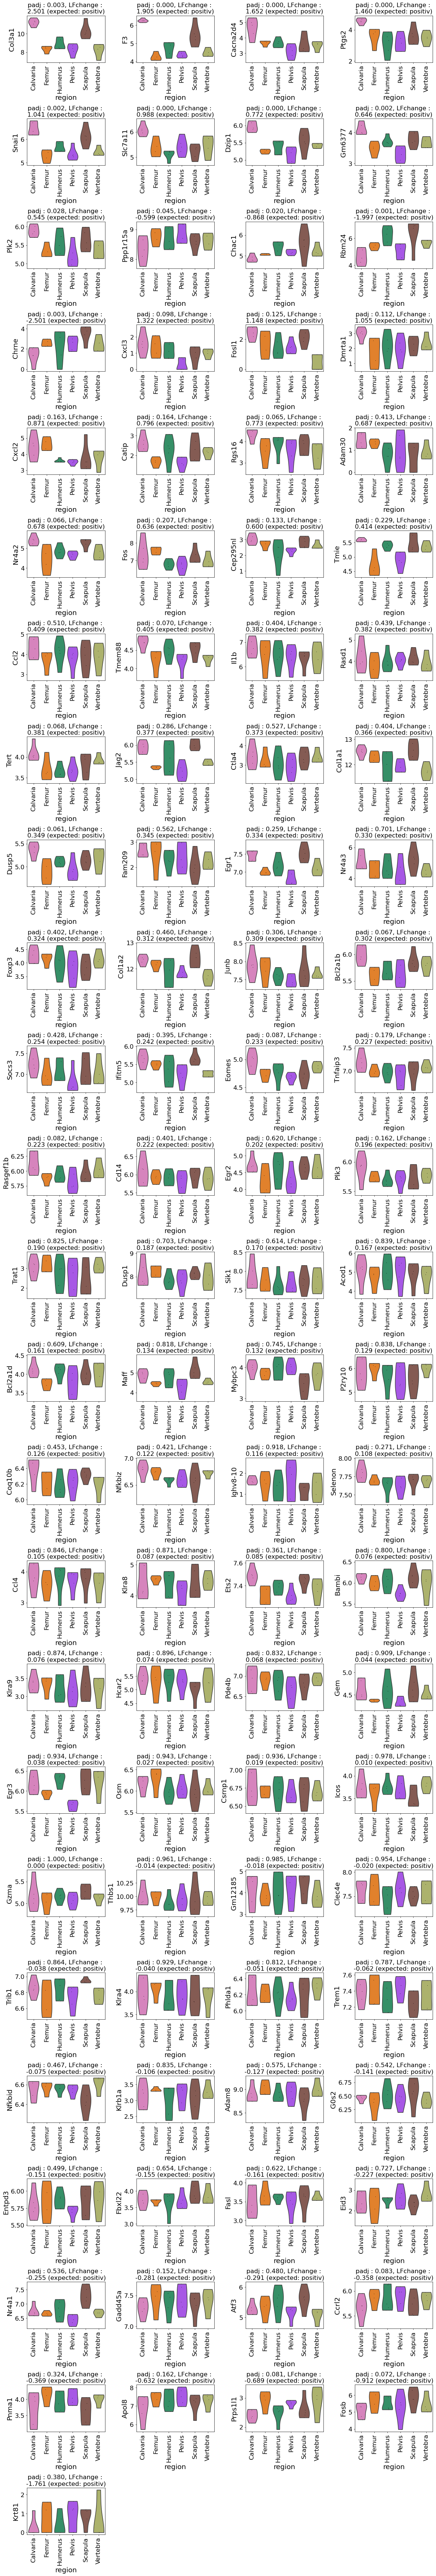

n genes
	 n_genes : 78
	 same trend : 19
	 significant : 28
	 same trend and significant : 4
	opposite trend and significant : 24


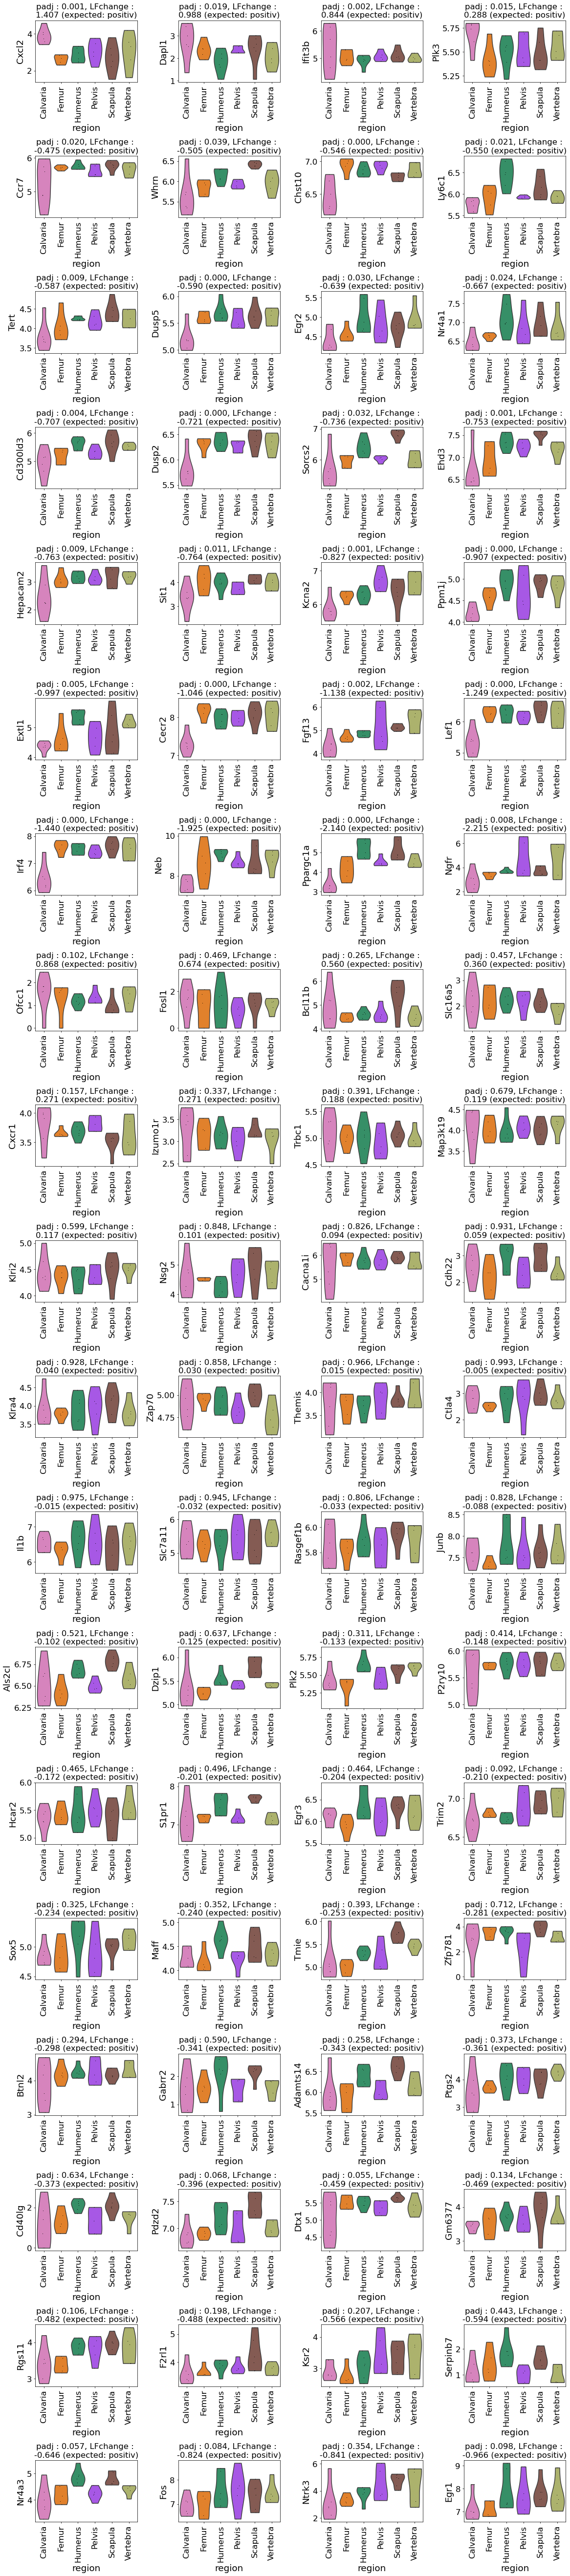

n genes
	 n_genes : 62
	 same trend : 48
	 significant : 22
	 same trend and significant : 21
	opposite trend and significant : 1


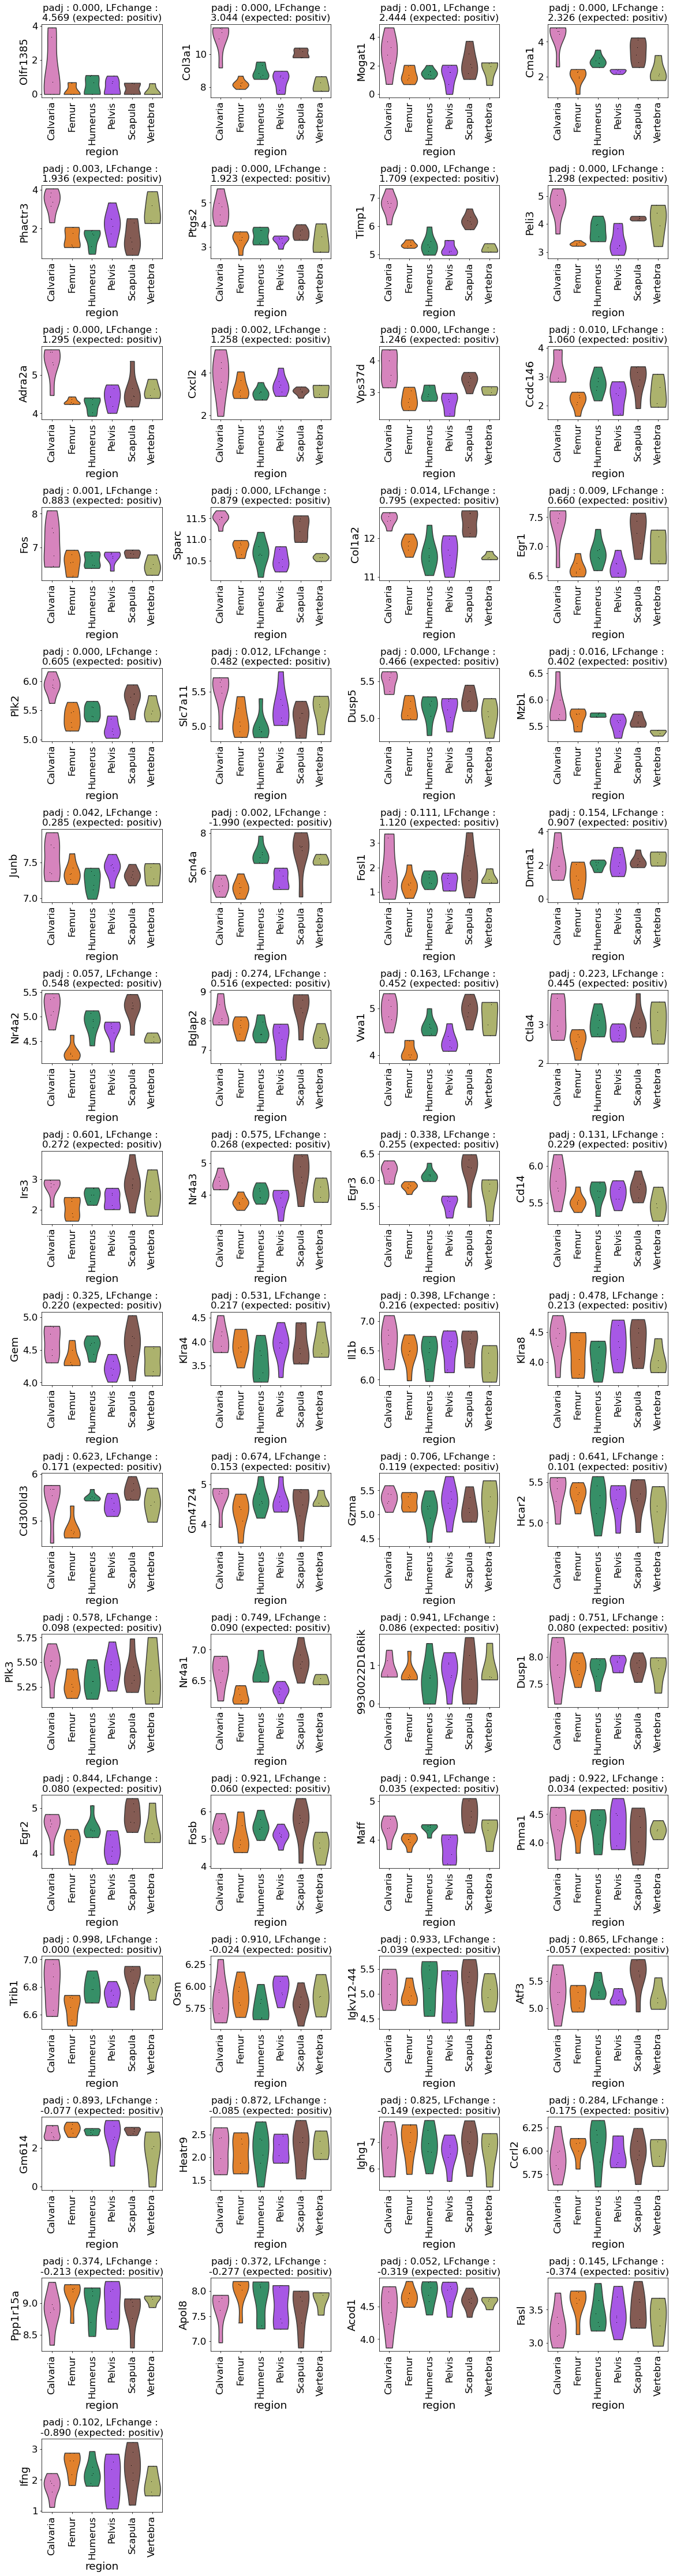

condition                       Naive  Sham  MCAo
n_genes                            98    78    62
same trend as sc                   69    19    48
significant                        13    28    22
same trend and significant          9     4    21
opposite trend and significant      4    24     1

In [25]:
# Load lists of skull upregulated genes for each condition (two versions: CD45+ only, and all cell types)
cond_sc = lambda cond: "MCAO" if cond == "MCAo" else cond

gene_lists = {}
rows = []

for condition in ["Naive", "Sham", "MCAo"]:
    df = pd.read_csv(Path(Path(RESULTS_DIR).parent, "DE_tests", "DE_tests_bulk", f"DE_genes_bulk_CD45_{cond_sc(condition)}_skull_vs_rest_LFchange_1.csv"),index_col=0)
    
    genes_cd45 = [g for g in df["names"].values if g in adata.var_names]
    #gene_lists[f"DE_genes_bulk_CD45_{cond_sc(condition)}_skull_vs_rest_LFchange_1"] = genes
                     
    df = pd.read_csv(Path(Path(RESULTS_DIR).parent, "DE_tests", "DE_tests_bulk", f"DE_genes_bulk_{cond_sc(condition)}_skull_vs_rest_LFchange_1.csv"),index_col=0)
    
    genes = [g for g in df["names"].values if g in adata.var_names]
    genes = np.unique(genes+genes_cd45).tolist()
    #gene_lists[f"DE_genes_bulk_{cond_sc(condition)}_skull_vs_rest_LFchange_1"] = genes
                     
    df_DE = pd.read_csv(Path(RESULTS_DIR,"DE_tests",f"condition_{condition}_region_Calvaria_vs_other.csv"), index_col=0)
    df_DE["gene"] = convert_ids_to_symbols(df_DE.index.tolist())
    a = adata[adata.obs["condition"]==condition,genes].copy()
    a.uns["region_colors"] = [region_to_color[r] for r in adata.obs["region"].astype('category').cat.categories]
    
    df_DE = df_DE.loc[df_DE["gene"].isin(genes)]
    df_DE = df_DE.sort_values("log2FoldChange", ascending=False)
    
    df_DE["same_trend"] = df_DE["log2FoldChange"] > 0
    df_DE["significant"] = df_DE["padj"] < 0.05
    df_DE["same_trend_and_sign"] = df_DE["same_trend"] & df_DE["significant"]
    df_DE["opposite_trend_and_sign"] = ~df_DE["same_trend"] & df_DE["significant"]
    
    print(
        f"n genes\n\t n_genes : {len(genes)}\n\t same trend : {df_DE['same_trend'].sum()}\n\t significant : {df_DE['significant'].sum()}" +
        f"\n\t same trend and significant : {df_DE['same_trend_and_sign'].sum()}\n\t" + 
        f"opposite trend and significant : {df_DE['opposite_trend_and_sign'].sum()}"
    )
    rows.append([condition, len(genes), df_DE['same_trend'].sum(), df_DE['significant'].sum(), df_DE['same_trend_and_sign'].sum(), df_DE['opposite_trend_and_sign'].sum()])
    
    df_DE_tmp = df_DE.sort_values(
            ["same_trend_and_sign","significant","same_trend","log2FoldChange"], 
            ascending=[False,False,False,False]
    )
    df_DE_tmp.to_excel(Path(RESULTS_DIR, "check_DE_genes_of_sc_pseudobulk", f"sc_Calvaria_up_{condition}_genes_bulk_stats.xlsx"))
    genes_pl = [g for g in df_DE_tmp["gene"] if g in genes]
    
    violin_plots(
        a, genes_pl, "region", df_DE,  #df_DE["gene"].tolist()
        save=f"../figures/bulk_RNA_check_sc_pseudobulk/sc_Calvaria_up_{condition}_genes_bulk.pdf"#"/Users/louis.kuemmerle/Promotion/projects/A1/files_to_Ilgin/230123_tbi_5xfad_DE_genes/expression_levels_sc_genes/TBI_DE_up_Skull_Sham_Skull_Femur.png"
    )    
    
    
    #display(df_DE)
    
    
df_overview = pd.DataFrame(
    columns = ["condition", "n_genes", "same trend as sc", "significant", "same trend and significant", "opposite trend and significant"],
    data = rows
).set_index("condition").T
display(df_overview)
df_overview.to_excel(Path(RESULTS_DIR, "check_DE_genes_of_sc_pseudobulk", "sc_Calvaria_up_overiew_n_genes_of_same_trend.xlsx"))
            

n genes
	 n_genes : 1151
	 same trend : 572
	 significant : 385
	 same trend and significant : 101
	opposite trend and significant : 284


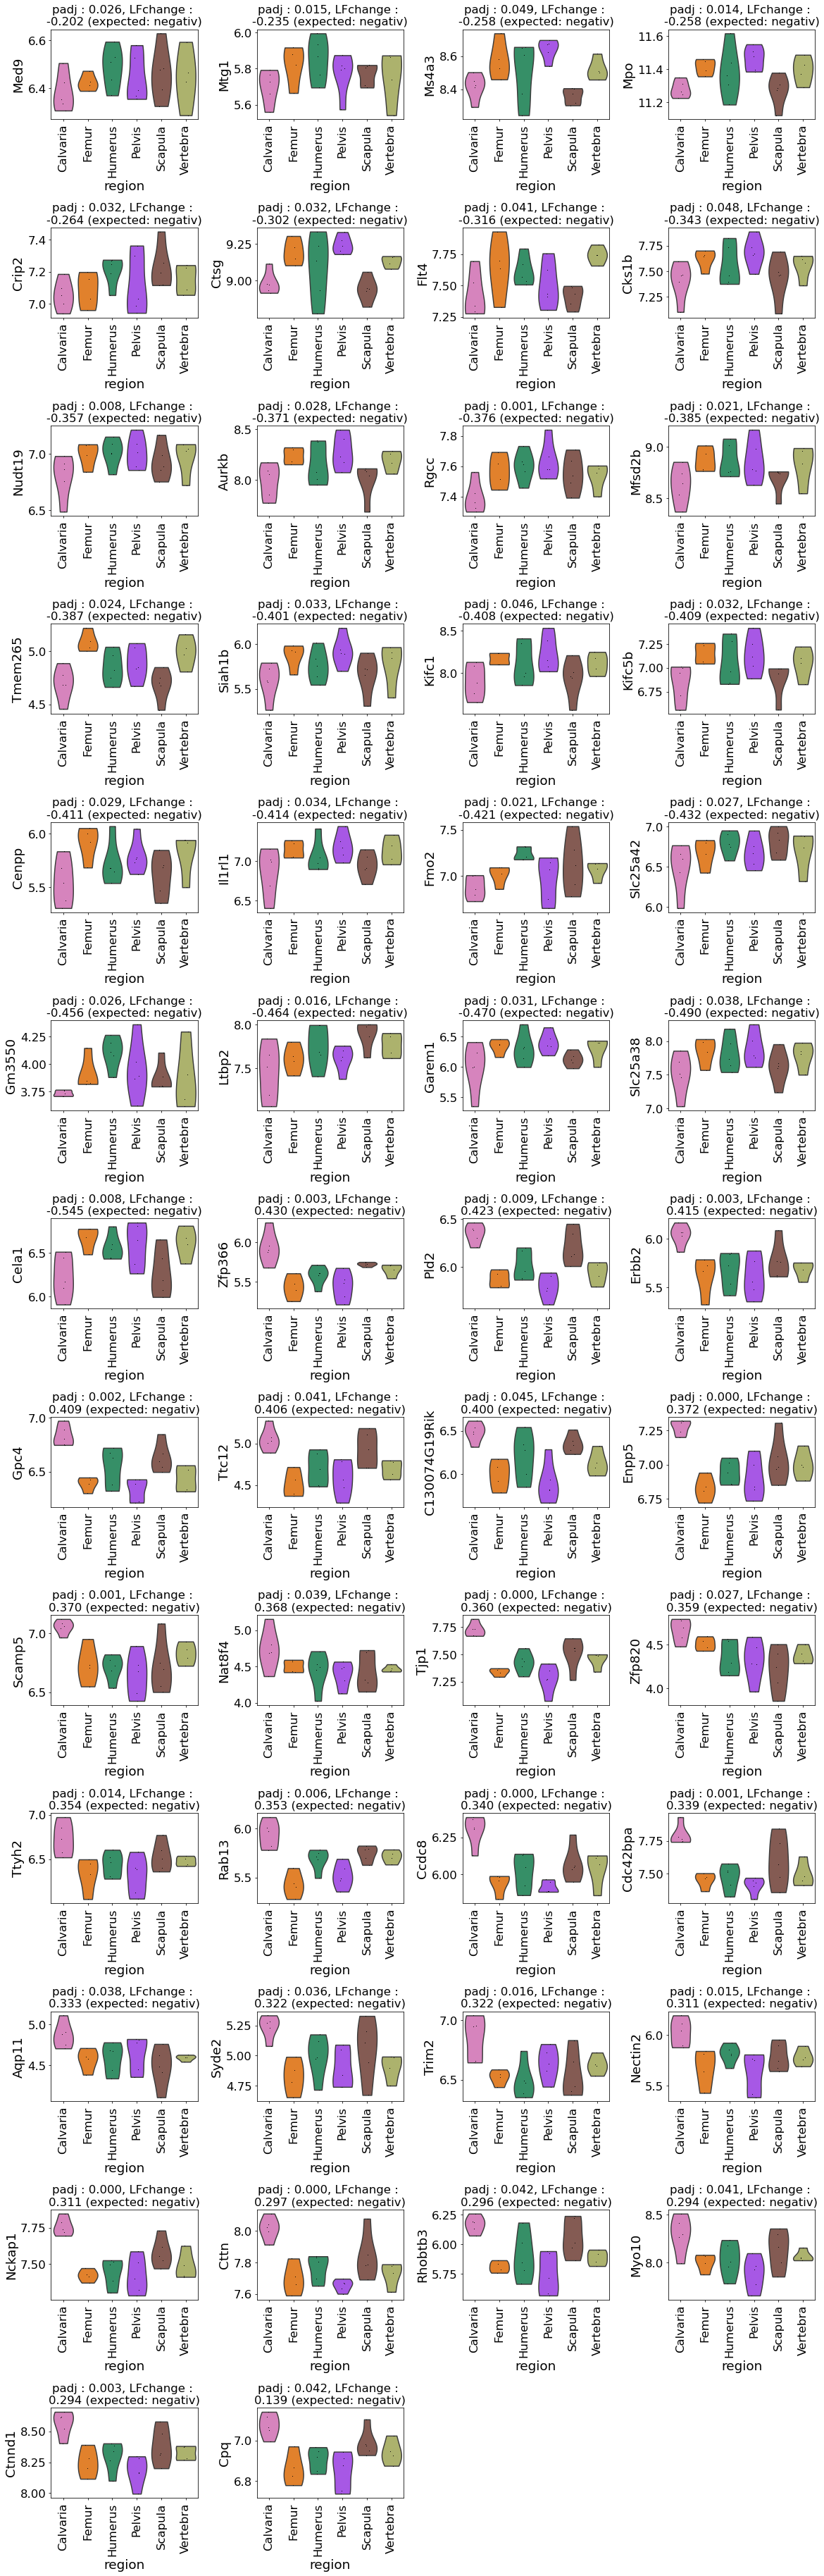

n genes
	 n_genes : 2149
	 same trend : 1156
	 significant : 642
	 same trend and significant : 360
	opposite trend and significant : 282


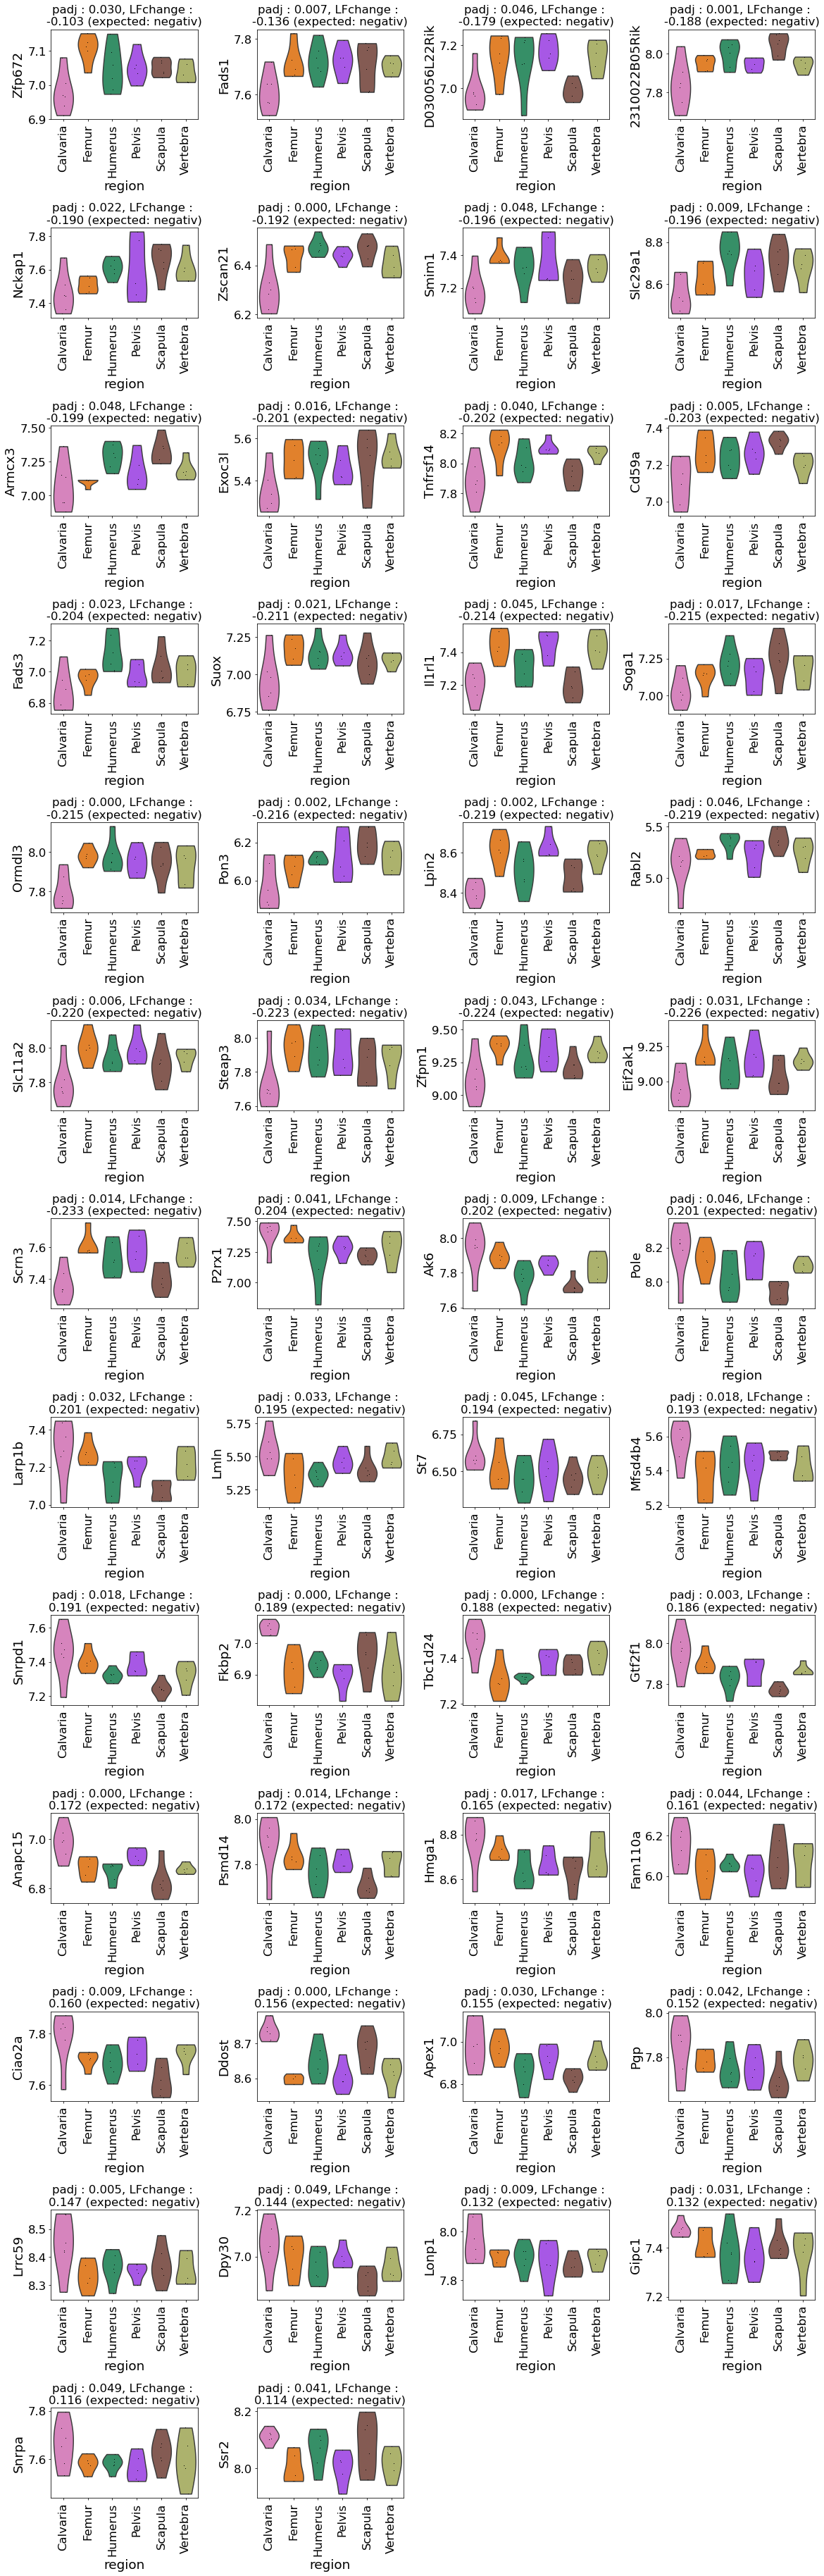

n genes
	 n_genes : 1426
	 same trend : 643
	 significant : 659
	 same trend and significant : 183
	opposite trend and significant : 476


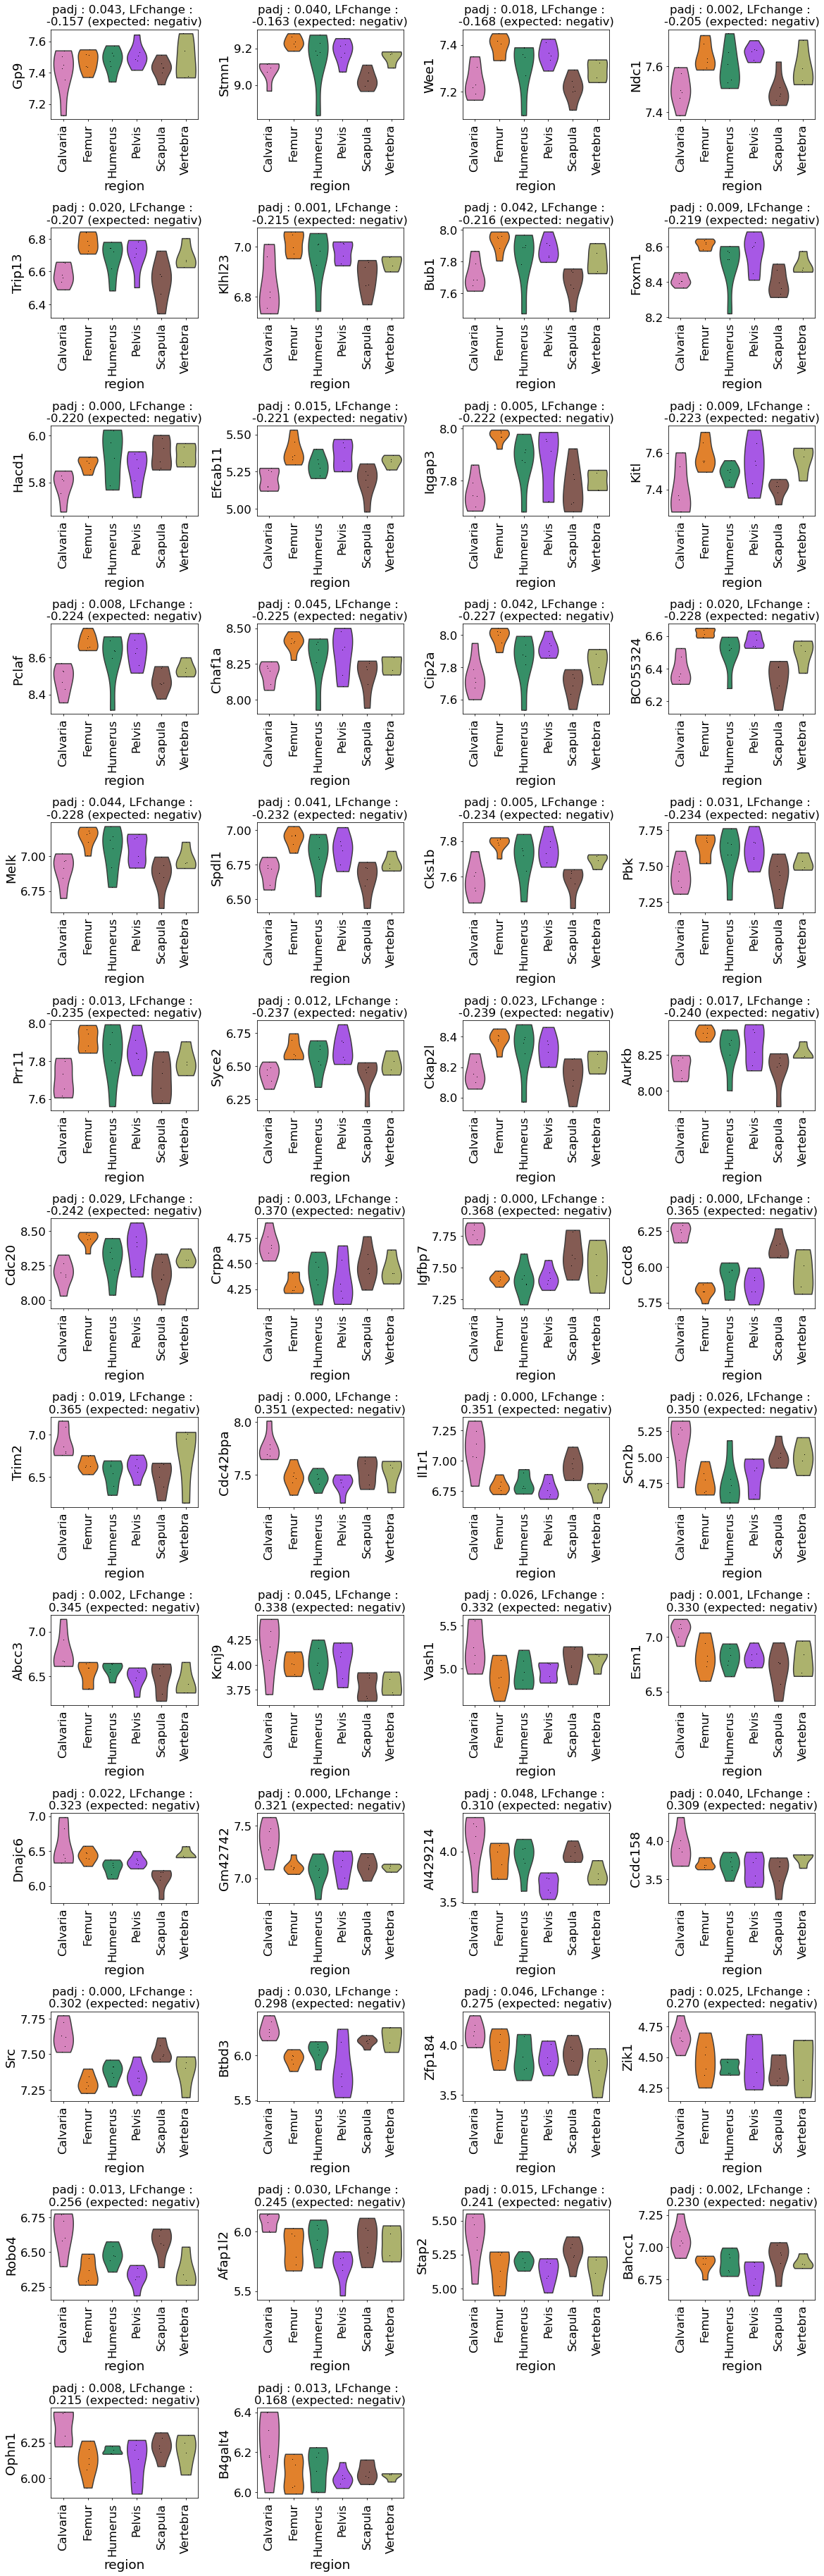

condition                       Naive  Sham  MCAo
n_genes                          1151  2149  1426
same trend as sc                  572  1156   643
significant                       385   642   659
same trend and significant        101   360   183
opposite trend and significant    284   282   476

In [19]:
# Load lists of skull downregulated genes for each condition (two versions: CD45+ only, and all cell types)
cond_sc = lambda cond: "MCAO" if cond == "MCAo" else cond

N_MAX_VIOLINS = 50

gene_lists = {}
rows = []

for condition in ["Naive", "Sham", "MCAo"]:
    df = pd.read_csv(Path(Path(RESULTS_DIR).parent, "DE_tests", "DE_tests_bulk", f"DE_genes_bulk_CD45_{cond_sc(condition)}_rest_vs_skull_LFchange_1.csv"),index_col=0)
    
    genes_cd45 = [g for g in df["names"].values if g in adata.var_names]
    #gene_lists[f"DE_genes_bulk_CD45_{cond_sc(condition)}_skull_vs_rest_LFchange_1"] = genes
                     
    df = pd.read_csv(Path(Path(RESULTS_DIR).parent, "DE_tests", "DE_tests_bulk", f"DE_genes_bulk_{cond_sc(condition)}_rest_vs_skull_LFchange_1.csv"),index_col=0)
    
    genes = [g for g in df["names"].values if g in adata.var_names]
    genes = np.unique(genes+genes_cd45).tolist()
    #gene_lists[f"DE_genes_bulk_{cond_sc(condition)}_skull_vs_rest_LFchange_1"] = genes
                     
    df_DE = pd.read_csv(Path(RESULTS_DIR,"DE_tests",f"condition_{condition}_region_Calvaria_vs_other.csv"), index_col=0)
    df_DE["gene"] = convert_ids_to_symbols(df_DE.index.tolist())
    a = adata[adata.obs["condition"]==condition,genes].copy()
    a.uns["region_colors"] = [region_to_color[r] for r in adata.obs["region"].astype('category').cat.categories]
    
    df_DE = df_DE.loc[df_DE["gene"].isin(genes)]
    df_DE = df_DE.sort_values("log2FoldChange", ascending=False)
    
    # Not the df_DE tests calvaria_vs_rest whereas the pseudobulk df tested rest_vs_calvaria
    df_DE["same_trend"] = df_DE["log2FoldChange"] < 0
    df_DE["significant"] = df_DE["padj"] < 0.05
    df_DE["same_trend_and_sign"] = df_DE["same_trend"] & df_DE["significant"]
    df_DE["opposite_trend_and_sign"] = ~df_DE["same_trend"] & df_DE["significant"]
    
    print(
        f"n genes\n\t n_genes : {len(genes)}\n\t same trend : {df_DE['same_trend'].sum()}\n\t significant : {df_DE['significant'].sum()}" +
        f"\n\t same trend and significant : {df_DE['same_trend_and_sign'].sum()}\n\t" + 
        f"opposite trend and significant : {df_DE['opposite_trend_and_sign'].sum()}"
    )
    rows.append([condition, len(genes), df_DE['same_trend'].sum(), df_DE['significant'].sum(), df_DE['same_trend_and_sign'].sum(), df_DE['opposite_trend_and_sign'].sum()])
    
    df_DE_tmp = df_DE.sort_values(
            ["same_trend_and_sign","significant","same_trend","log2FoldChange"], 
            ascending=[False,False,False,False]
    )
    df_DE_tmp.to_excel(Path(RESULTS_DIR, "check_DE_genes_of_sc_pseudobulk", f"sc_Calvaria_down_{condition}_genes_bulk_stats.xlsx"))
    if len(df_DE_tmp.loc[df_DE_tmp["significant"]]) > N_MAX_VIOLINS:
        z = N_MAX_VIOLINS//2
        genes_pl = [g for g in df_DE_tmp["gene"].loc[df_DE_tmp["significant"]].iloc[np.r_[0:z, -z:0]] if g in genes]
    elif len(df_DE_tmp.loc[df_DE_tmp["significant"]]) > N_MAX_VIOLINS:
        z = N_MAX_VIOLINS//2
        genes_pl = [g for g in df_DE_tmp["gene"].iloc[np.r_[0:z, -z:0]] if g in genes]
    else:
        genes_pl = [g for g in df_DE_tmp["gene"] if g in genes]
    
    #display(df_DE)
    
    violin_plots(
        a, genes_pl, "region", df_DE,  #df_DE["gene"].tolist()
        save=f"../figures/bulk_RNA_check_sc_pseudobulk/sc_Calvaria_down_{condition}_genes_bulk.pdf",#"/Users/louis.kuemmerle/Promotion/projects/A1/files_to_Ilgin/230123_tbi_5xfad_DE_genes/expression_levels_sc_genes/TBI_DE_up_Skull_Sham_Skull_Femur.png"
        expectation = "expected: negativ"
    )    
    
    
    #display(df_DE)
    
    
df_overview = pd.DataFrame(
    columns = ["condition", "n_genes", "same trend as sc", "significant", "same trend and significant", "opposite trend and significant"],
    data = rows
).set_index("condition").T
display(df_overview)
df_overview.to_excel(Path(RESULTS_DIR, "check_DE_genes_of_sc_pseudobulk", "sc_Calvaria_down_overiew_n_genes_of_same_trend.xlsx"))
